# Classification Model Part
 - Load Data
 - Demonstrate shape of main dataset and adding features

In [43]:
import pandas as pd

atb = pd.read_csv('data.csv')
read_score = pd.read_csv('readScore.csv')
pos = pd.read_csv('pos.csv')
liwc = pd.read_csv('features_liwc.csv')
doctop = pd.read_csv('docTopDist.csv')

print(atb.shape)
print(read_score.shape)
print(pos.shape)
print(liwc.shape)
print(doctop.shape)

(52651, 48)
(52651, 1)
(52651, 5)
(52651, 4)
(52651, 12)


### drop non-related columns and null values

In [44]:
doctop.columns
doctop = doctop.drop(['group_2'], axis=1)

In [45]:

data = pd.concat([atb,read_score,liwc, pos, doctop], axis=1)
print(data.shape)
#data['Clout'].isnull().any()
#np.argwhere(data['flesch_score'].isnan(x))
data = data.dropna(axis=0, subset=['flesch_score'])
data.shape

(52651, 69)


(52499, 69)

- Adding time feature by subtracting launch time from deadline with unix time stamp

In [46]:
from sklearn import preprocessing
data['duration'] = data['deadline'] - data['launched_at']
#data['duration'].head(10)

le = preprocessing.LabelEncoder()
le.fit(data['state'].values)
data['state_le'] = le.transform(data['state'].values) 

data.state_le.unique()

array([0, 1], dtype=int64)

- check feature importance of each group of topic distribution by applying random forest

In [24]:

from sklearn.ensemble import RandomForestRegressor
import numpy as np
#Load boston housing dataset as an example
x_raw = data[['group_1', 'group_3', 'group_4', 'group_5', 'group_6',
       'group_7', 'group_8', 'group_9', 'group_10', 'group_11', 'group_12']].values
X = preprocessing.scale(x_raw)
y = data['state_le'].values

names = ['group_1', 'group_3', 'group_4', 'group_5', 'group_6',
       'group_7', 'group_8', 'group_9', 'group_10', 'group_11', 'group_12']
rf = RandomForestRegressor()
rf.fit(X, y)
print(rf.feature_importances_)
print ("Topics sorted by thier score of feature importance:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

C:\Users\Young\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.14631489 0.0790702  0.12504166 0.07489351 0.07620397 0.07007033
 0.08325906 0.11478947 0.01783478 0.1209335  0.09158864]
Topics sorted by thier score of feature importance:
[(0.1463, 'group_1'), (0.125, 'group_4'), (0.1209, 'group_11'), (0.1148, 'group_9'), (0.0916, 'group_12'), (0.0833, 'group_8'), (0.0791, 'group_3'), (0.0762, 'group_6'), (0.0749, 'group_5'), (0.0701, 'group_7'), (0.0178, 'group_10')]


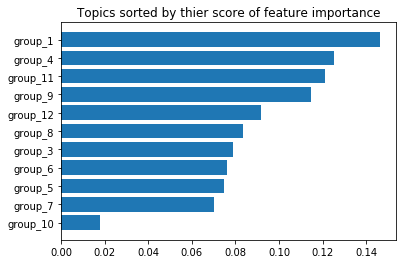

In [42]:
import matplotlib.pyplot as plt
import numpy as np

a = [(0.1463, 'group_1'), (0.125, 'group_4'), (0.1209, 'group_11'), (0.1148, 'group_9'), (0.0916, 'group_12'), (0.0833, 'group_8'), 
 (0.0791, 'group_3'), (0.0762, 'group_6'), (0.0749, 'group_5'), (0.0701, 'group_7'), (0.0178, 'group_10')]

x = [i[1] for i in reversed(a)]
y = [i[0] for i in reversed(a)]

plt.barh(x, y)
plt.title("Topics sorted by thier score of feature importance")
plt.show()

In [6]:
data.columns.values

array(['Unnamed: 0', 'backers_count', 'blurb', 'category',
       'converted_pledged_amount', 'country', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'friends',
       'fx_rate', 'goal', 'id', 'is_backing', 'is_starrable',
       'is_starred', 'launched_at', 'location', 'name', 'permissions',
       'photo', 'pledged', 'profile', 'slug', 'source_url', 'spotlight',
       'staff_pick', 'state', 'state_changed_at', 'static_usd_rate',
       'urls', 'usd_pledged', 'usd_type', 'project_id', 'url',
       'script_dict', 'title', 'progress', 'descripton', 'risk', 'reward',
       'create_by', 'category and location', 'flesch_score', 'Analytic',
       'Clout', 'Authentic', 'Tone', 'adj', 'comp', 'sup', 'adv', 'pst',
       'group_1', 'group_3', 'group_4', 'group_5', 'group_6', 'group_7',
       'group_8', 'group_9', 'group_10', 'group_11', 'group_12',
       'duration', 'state_le'], dt

In [21]:
from sklearn import preprocessing   
import numpy as np 
x_raw = data[['goal', 'duration','flesch_score', 'adj', 'comp', 'sup', 'adv']].values #'backers_count'
print(x_raw.shape)
X = preprocessing.scale(x_raw)
y = data['state_le'].values

(52499, 7)


- testing the performance of PCA, the result is not good

In [ ]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=30000)
dtm_tsvd = tsvd.fit(dtm).transform(dtm)
tsvd.explained_variance_ratio_[0:30000].sum()

## Model Selection
- Choose different fraction of sample size, i.e. 20%, 40%, 60%, 80% and full samples
- Split the training and testing features for each fraction
- Find the test f1 macro score for each model
- Compute the running time for each model


In [53]:
############# model selection #################
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

names = ["Linear SVM",
         "Perceptron",
         "LogisticRegression",
         "Decision Tree", 
            ] 

classifiers = [ 
    LinearSVC(C = 0.000005),
    Perceptron(),
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=5),
                 ]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.3, 
                            random_state=0)

    
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
    
    
for name, clf in zip(names, classifiers):
    start = time.process_time()
    pipe = Pipeline( [ ('scl', StandardScaler(with_mean=False)),
                   #('pca', PCA(n_components = 5)),
                   ('clf', clf)])
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)


    end = time.process_time()
    duration = end - start
    print("{0:20s}  f1_Score: {1:0.4f}  Time: {2:0.4f}seconds ".format(name, score, duration))

# Do you need PCA here? How's the performance with and without PCA?
# How can you find the best features? (Hint: RF)

Linear SVM            f1_Score: 0.7997  Time: 4.1094seconds 
Perceptron            f1_Score: 0.7267  Time: 2.2500seconds 
LogisticRegression    f1_Score: 0.7760  Time: 87.3906seconds 
Decision Tree         f1_Score: 0.7304  Time: 18.3125seconds 


- record the observeation result for running time and f1 score for each model

In [37]:
size = [0.2, 0.4, 0.6, 0.8, 1]
svm_t = [0.6719, 1.8438, 7.3281, 3.2344, 4.1094]
per_t = [0.4375, 1.0625, 1.6250, 1.8594, 4.1094]
lr_t = [6.8750, 16.1094, 37.0000, 57.437, 87.3906]
dt_t = [2.8281, 6.0469, 9.7969, 13.8594, 18.3125]
svm_f = [0.7406, 0.7746, 0.7888, 0.7907, 0.7997]
per_f = [0.6838, 0.7051, 0.7166, 0.7217, 0.7267]
lr_f = [0.7654, 0.7741, 0.7796, 0.7746, 0.7760]
dt_f = [0.7156, 0.7144, 0.7128, 0.7233, 0.7304]

- plot the running times of models

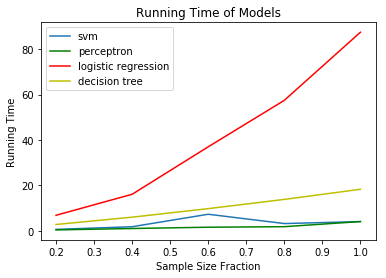

In [40]:
import matplotlib.pyplot as plt

plt.plot(size, svm_t,  label = "svm")
plt.plot(size, per_t, color = "g", label = "perceptron")
plt.plot(size, lr_t, color = "r", label = "logistic regression")
plt.plot(size, dt_t, color = "y", label = "decision tree")

plt.xlabel('Sample Size Fraction')
plt.ylabel('Running Time')
plt.title('Running Time of Models')
plt.legend()
plt.show()

- plot f1 score of models

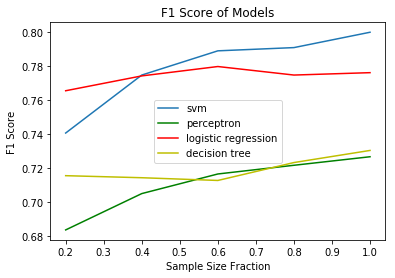

In [41]:
plt.plot(size, svm_f,  label = "svm")
plt.plot(size, per_f, color = "g", label = "perceptron")
plt.plot(size, lr_f, color = "r", label = "logistic regression")
plt.plot(size, dt_f, color = "y", label = "decision tree")

plt.xlabel('Sample Size Fraction')
plt.ylabel('F1 Score')
plt.title('F1 Score of Models')
plt.legend()
plt.show()

## Creating TFIDF sparse matrix

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize the TfidfVectorizer 

tfidf_vect = TfidfVectorizer(stop_words='english', min_df = 1) 

# with stop words removed
#tfidf_vect = TfidfVectorizer(stop_words="english") 

# generate tfidf matrix
dtm= tfidf_vect.fit_transform(data["descripton"])

print("type of dtm:", type(dtm))
print("size of tfidf matrix:", dtm.shape)

type of dtm: <class 'scipy.sparse.csr.csr_matrix'>
size of tfidf matrix: (52499, 301964)


## Data Prepreation before feeding into models
- standrized all features
- Combining all the features in to sparse matrices
- changing 'X' each time when adding new features

In [58]:
from scipy import sparse
x_raw = data[['goal', 'duration', 'flesch_score', 'adj', 'comp', 'sup', 'adv', 'pst','Analytic' ,'Clout', 'Authentic', 'Tone',\
             'group_1',  'group_3', 'group_4', 'group_5', 'group_6',\
             'group_7', 'group_8', 'group_9', 'group_10', 'group_11']].values      #'flesch_score', 'adj', 'comp', 'sup', 'adv', 'pst','Analytic' ,'Clout', 'Authentic', 'Tone'
X = preprocessing.scale(x_raw)
sp_x_o = sparse.csr_matrix(X)
print(sp_x_o.shape)

dtm_x = preprocessing.scale(dtm, with_mean=False)
from scipy.sparse import hstack
sp_x = hstack((dtm_x, sp_x_o))
sp_xx = hstack((dtm,sp_x_o))
y = data['state_le'].values

print(dtm.shape)
print(sp_x.shape)

(52499, 22)
(52499, 301964)
(52499, 301986)


## classification model of logistic regression

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(\
                spx_x, y, test_size=0.3, random_state=0)
#clf = svm.LinearSVC(C = 0.000005).fit(X_train, y_train)
lr = LogisticRegression(C=10).fit(X_train, y_train)
predicted=lr.predict(X_test)
labels=sorted(data["state_le"].unique())

precision, recall, fscore, support=\
     precision_recall_fscore_support(\
     y_test, predicted, labels=labels)

print("labels: ", labels)
print("precision: ", precision)
print("recall: ", recall)
print("f-score: ", fscore)
print("support: ", support)

# another way to get all performance metrics
print(classification_report(y_test, predicted))

labels:  [0, 1]
precision:  [0.72030518 0.81278173]
recall:  [0.68968952 0.83417292]
f-score:  [0.70466497 0.82333841]
support:  [6023 9727]
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      6023
           1       0.81      0.83      0.82      9727

   micro avg       0.78      0.78      0.78     15750
   macro avg       0.77      0.76      0.76     15750
weighted avg       0.78      0.78      0.78     15750



## Grid search for Logistic Regression
- set parameter from 1 to 100, with the step 10
- get the 'C' of best cross validation score when adding new features

In [88]:
import numpy as np
from sklearn.pipeline import Pipeline
lrpipe = Pipeline([('scale', StandardScaler(with_mean=False)),
                   ('LR',LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.3, 
                            random_state=0)

param_grid = {'LR__C':np.arange(1,100,10)}
#param_grid = {'LR__C':np.arange(100,10000,1000)}
metric =  "f1_macro"
LR = GridSearchCV(lrpipe,param_grid,scoring=metric, cv=5,return_train_score=True)
LR.fit(X_train,y_train)

for param_name in LR.best_params_:
    print(param_name,": ",LR.best_params_[param_name])

print("best f1 score:", LR.best_score_)

LR__C :  51
best f1 score: 0.6898704985757302


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# import method to calculate metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

# split dataset into train (70%) and test sets (30%)
X_train, X_test, y_train, y_test = train_test_split(\
                sp_x, y, test_size=0.3, random_state=0)

from sklearn.model_selection import cross_validate
#from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm

metrics = ['precision_macro', 'recall_macro', "f1_macro"]

# initiate an linear SVM model
clf = svm.LinearSVC(dual = False , C = 0.01).fit(X_train, y_train)
predicted=clf.predict(X_test)
labels=sorted(data["state_le"].unique())

precision, recall, fscore, support=\
     precision_recall_fscore_support(\
     y_test, predicted, labels=labels)

print("labels: ", labels)
print("precision: ", precision)
print("recall: ", recall)
print("f-score: ", fscore)
print("support: ", support)

# another way to get all performance metrics
print(classification_report(y_test, predicted))

labels:  [0, 1]
precision:  [0.71906641 0.81527764]
recall:  [0.69566661 0.83170556]
f-score:  [0.707173   0.82340967]
support:  [6023 9727]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      6023
           1       0.82      0.83      0.82      9727

   micro avg       0.78      0.78      0.78     15750
   macro avg       0.77      0.76      0.77     15750
weighted avg       0.78      0.78      0.78     15750



C:\Users\Young\Miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Grid search for linear SVM
- set parameter from 0.01 to 10, with the step 0.05
- get the 'C' of best cross validation score

In [ ]:
SVCpipe = Pipeline([('scale', StandardScaler()),
                   ('SVC',LinearSVC())])

param_grid = {'SVC__C':np.arange(0.01,10,0.05)}
metric =  "f1_macro"
linearSVC = GridSearchCV(SVCpipe,param_grid,scoring=metric, cv=5,return_train_score=True)
linearSVC.fit(X_train,y_train)
#print(linearSVC.best_params_)

for param_name in linearSVC.best_params_:
    print(param_name,": ",linearSVC.best_params_[param_name])

print("best f1 score:", linearSVC.best_score_)

## Performance as adding textual features from the baseline
- From the baseline, we add the textual features step by step depending on their dimensions, aiming to see how each feature would have effects on macro F1 score.


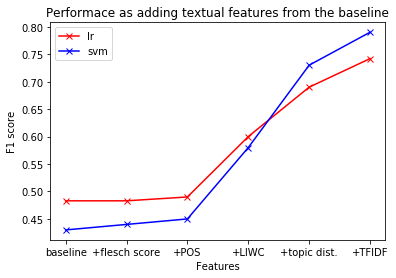

In [94]:
import matplotlib.pyplot as plt
lr = [0.483, 0.483,  0.49, 0.6, 0.69, 0.742]
svm = [0.43, 0.44, 0.45, 0.58, 0.73, 0.79]
c_lr = [51, 21, 31, 51, 41]
c_svm = [C=0.91, C=2.56, C=3.51, C=2.11 ,C=0.51, C=5e-6]

features = ['baseline', '+flesch score', '+POS', '+LIWC', '+topic dist.', '+TFIDF']

plt.plot(features, lr , 'bx-', color = "r", label = "lr"  )
plt.plot(features, svm, 'bx-', label = "svm" )

plt.xlabel('Features')
plt.ylabel('F1 score')
plt.title('Performace as adding textual features from the baseline')
plt.legend()
plt.show()